In [34]:
import numpy as np
from random import randint
import random
import matplotlib.pyplot as plt
import math
import sys
import scipy as sp
import numpy.linalg as la
from google.colab import drive

#Functions

In [35]:
def sign(x):
    if x < 0:
        return -1
    else:
        return 1

In [36]:
def createWeights(nbNeurons, train):
    w = np.zeros([nbNeurons, nbNeurons])
    data = np.asarray(train)
    w = np.matmul(data.T, data)
    for i in range (nbNeurons):
        w[i][i] = 0
    return np.asarray(w)

In [37]:
def flip(v, n):
    vec = np.copy(v)
    chosen = random.sample(range(len(vec)), n)
    for a in chosen:
        vec[a] *= -1
    return vec

In [38]:
def sequentialUpdate(weights, pattern, node):
    new = np.copy(pattern)
    sum = 0
    for j in range(len(pattern)):
        sum += weights[node][j] * pattern[j]
    new[node] = sign(sum)
    return new

In [39]:
def update(weights, pattern):
    new = np.matmul(weights, pattern)
    return ((np.vectorize(sign))(new))

In [40]:
def convergeSequential(weights, train, dim, max, epoch):
    E = []
    node = randint(0, dim)
    input = sequentialUpdate(weights, train, node)
    for tried in range(max):
        node = randint(0, dim)
        inputNew = sequentialUpdate(weights, train, node)
        input = inputNew
        if ((tried%epoch) == 0):
            E.append(energy(weights, input))
    return (np.asarray(inputNew), E)

In [41]:
def convergeSequential2(weights, train, dim, max, epoch):
    E = []
    input = sequentialUpdate(train, weights)
    for tried in range(max):
        inputNew = sequentialUpdate(train, weights)
        input = inputNew
        if ((tried%epoch) == 0):
            E.append(energy(weights, input))
    return (np.asarray(inputNew), E)

In [42]:
def converge(weights, train, max):
    input = update(weights, train)
    maxTrials = max
    tried = 0
    while not(tried > maxTrials):
        inputNew = update(weights, input)
        input = inputNew
        tried += 1
    return np.asarray(inputNew)

#3.3 Energy

In [43]:
def energy(weights, patterns):
    E = 0
    for i in range(len(patterns)):
        for j in range(len(patterns)):
            E -= weights[i, j] * patterns[i] * patterns[j]
    return E

In [44]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
file = open("/content/drive/My Drive/KTH/NeuralNetwork/Lab3/pict.dat", "r")
pict = (file.readline()).split(",")
p = [[]]
for i in range(11):
    p.append(pict[(1024*i):(1024*(i+1))])
    p[i+1] = list(map(int, p[i+1]))
picWeights = createWeights(1024, [p[1], p[2], p[3]])
picWeights = np.asarray(picWeights)

In [46]:
normWeights = picWeights/(3.0)
# energy of attractors
for i in range(1, 4):
    e = energy(normWeights, p[i])
    print("Energy of attractor pattern p", i, " : ", e)
     

Energy of attractor pattern p 1  :  -490287.99999847374
Energy of attractor pattern p 2  :  -465114.6666661321
Energy of attractor pattern p 3  :  -498090.6666646041


In [47]:
# energy of distorted patterns
for i in range(10, 12):
    e = energy(normWeights, p[i])
    print("Energy of distorted pattern p", i, " : ", e)

Energy of distorted pattern p 10  :  -140963.99999992995
Energy of distorted pattern p 11  :  -58197.3333333378


In [49]:
# energy change -- Sequential update
dim = 1023
batch = 1000
epoch = 100
p10new, p10energy = convergeSequential(normWeights, p[10], dim, batch, epoch)


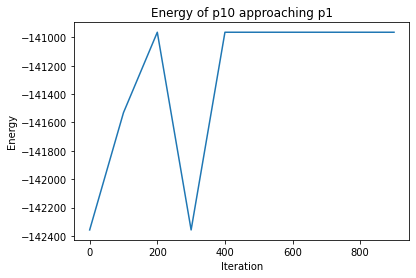

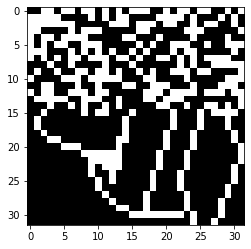

In [50]:
xaxis = np.arange(0, batch, epoch)
plt.plot(xaxis, p10energy)
plt.title("Energy of p10 approaching p1")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()
plt.figure(1)
plt.imshow(np.reshape((np.asarray(p10new)), (32, 32)), cmap='gray')

In [51]:
p11new, p11energy = convergeSequential(normWeights, p[11], dim, batch, epoch)


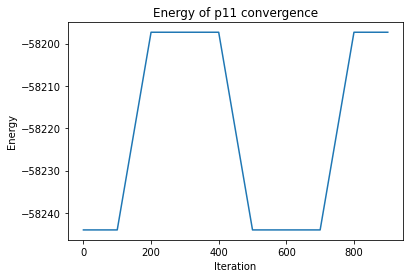

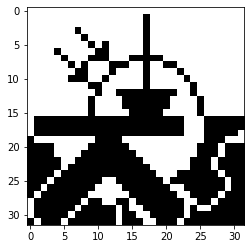

In [52]:
xaxis = np.arange(0, batch, epoch)
plt.plot(xaxis, p11energy)
plt.title("Energy of p11 convergence")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()
plt.figure(2)
plt.imshow(np.reshape((np.asarray(p11new)), (32, 32)), cmap='gray')

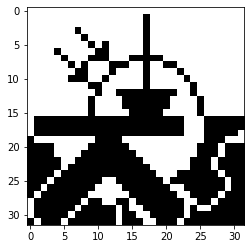

In [53]:
plt.imshow(np.reshape((np.asarray(p[11])), (32, 32)), cmap='gray')

In [54]:
bol = True
for i in range(dim):
    bol = (p[10][i]==p10new[i])
print(bol)

True


When we use the sequential update rule, from iteration to iteration, the energy doesn't converge, it keeps decrease then increase between two states. We can't achieve a stable energy.

In [55]:
# Random weights
randWeights = np.random.normal(size=(dim+1, dim+1))
for i in range(dim):
    randWeights[i][i] = 0

In [56]:
p10new, p10energy = convergeSequential(randWeights, p[10], dim, batch, epoch)

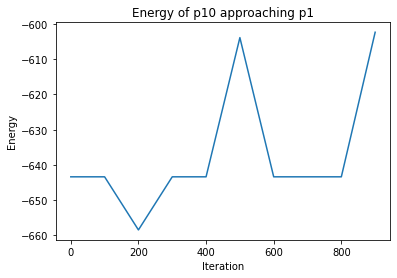

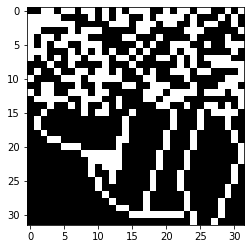

In [57]:
xaxis = np.arange(0, batch, epoch)
plt.plot(xaxis, p10energy)
plt.title("Energy of p10 approaching p1")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()
plt.figure(1)
plt.imshow(np.reshape((np.asarray(p10new)), (32, 32)), cmap='gray')

We observe that the energy is much higher, and the amplitude of wave is lower.

In [58]:
# Symmetric random weight 
randSymWeights = 0.5 * (randWeights + randWeights.T)
p10new, p10energy = convergeSequential(randSymWeights, p[10], dim, batch, epoch)

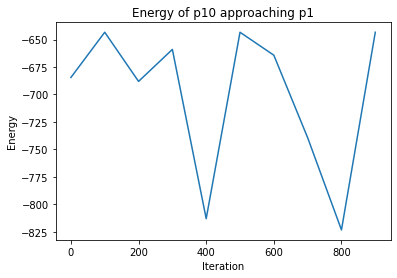

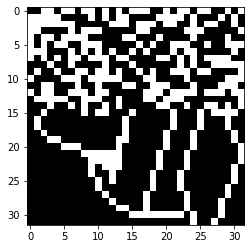

In [59]:
xaxis = np.arange(0, batch, epoch)
plt.plot(xaxis, p10energy)
plt.title("Energy of p10 approaching p1")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()
plt.figure(1)
plt.imshow(np.reshape((np.asarray(p10new)), (32, 32)), cmap='gray')

We observe that the pattern doesn't change, because it's stable.

# 3.4 Noise removal

In [60]:
# flip N percent of the bits One step
converged = []
convergedi = [[],[],[],[]]
for N in range(101):
    total = 0
    for i in range(1,4):
        noisy = flip(p[i], int(10.24 * N))
        noisyOut = converge(picWeights, noisy, 1)
        succ = np.array_equal(noisyOut, p[i])
        convergedi[i].append(1*succ)
        total += succ
    converged.append(total/3.)

Text(0, 0.5, 'Accuracy')

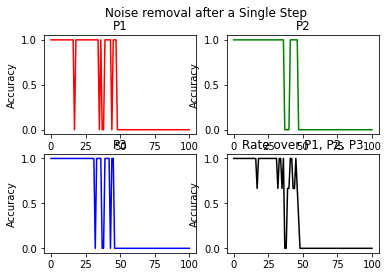

In [61]:
xaxis = np.arange(0, 101)

plt.figure()
plt.suptitle("Noise removal after a Single Step")

plt.subplot(2, 2, 1)
plt.plot(xaxis, convergedi[1], 'r', label='p1')
plt.title('P1')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(xaxis, convergedi[2], 'g', label='p2')
plt.title('P2')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 3)
plt.plot(xaxis, convergedi[3], 'b', label='p3')
plt.title('P3')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 4)
plt.plot(xaxis, converged, 'k', label='p1')
plt.title('Rate over P1, P2, P3')
plt.ylabel("Accuracy")

We observe that we can remove a maximum of 50% noise.

WIth regards to noise tolerance, we observe that the attractor P2 has the smallest error tolerance, its oscillation bearing is the shortest. And the attractor P3 has the biggest error tolerance.


In [ ]:
# flip N percent of the bits 10 Steps
converged = []
convergedi = [[],[],[],[]]
for N in range(101):
    total = 0
    for i in range(1,4):
        noisy = flip(p[i], int(10.24 * N))
        noisyOut = converge(picWeights, noisy, 10)
        succ = np.array_equal(noisyOut, p[i])
        convergedi[i].append(1*succ)
        total += succ
    converged.append(total/3.)

In [ ]:
xaxis = np.arange(0, 101)

plt.figure()
plt.suptitle("Noise removal after a Single Step")

plt.subplot(2, 2, 1)
plt.plot(xaxis, convergedi[1], 'r', label='p1')
plt.title('P1')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(xaxis, convergedi[2], 'g', label='p2')
plt.title('P2')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 3)
plt.plot(xaxis, convergedi[3], 'b', label='p3')
plt.title('P3')
plt.ylabel("Accuracy")

plt.subplot(2, 2, 4)
plt.plot(xaxis, converged, 'k', label='p1')
plt.title('Rate over P1, P2, P3')
plt.ylabel("Accuracy")

We observe that the oscillation bearing is long for some attractors, so the network doesn't always converge to the right network. 

But the extra iterations help, with 10 iterations, the network with P2 always converges to P2.



In [ ]:
plt.imshow(np.reshape((np.asarray(noisyOut)), (32, 32)), cmap='gray')

We observe there are other attractors which are the opposite of our current attractors.